In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
motat = pd.read_csv('../Data/motatstation_weather_auckland_2016_2024.csv', parse_dates=['Date'])
motat.head()

,Date,WDir(Deg),WSpd(m/s),GustDir(Deg),GustSpd(m/s),WindRun(Km),Rain(mm),Tdry(c),Twet(c),RH(%),...,ET10©,ET20©,ET100©,Pmsl(hPa),Pstn(hPa),Sun(Hrs),Rad(MJ/m2),Tavg,Evaporation(mm),SoilMoist(%)
0,2016-03-01,188.0,1.2,65.0,7.2,172.0,1.8,19.2,18.5,93.0,...,21.3,22.2,21.5,1014.4,1012.5,1.3,6.21,20.40,0.9,37.4
1,2016-03-02,157.0,3.2,60.0,9.3,258.0,0.0,17.9,16.1,82.0,...,20.4,21.7,21.5,1019.3,1017.4,7.6,15.02,20.25,1.8,37.6
2,2016-03-03,134.0,1.9,67.0,10.8,214.0,0.0,18.3,15.7,75.0,...,19.5,20.9,21.5,1028.0,1026.1,9.4,20.46,19.20,4.2,37.6
3,2016-03-04,147.0,1.3,38.0,6.2,134.0,0.0,19.4,16.1,69.0,...,19.9,21.2,21.6,1027.6,1025.7,9.3,19.20,19.60,4.2,37.7
4,2016-03-05,131.0,0.4,197.0,9.3,187.0,0.0,19.0,17.3,84.0,...,19.9,21.2,21.5,1025.6,1023.7,12.1,24.18,19.75,4.0,37.8


In [39]:
motat.set_index('Date', inplace=True)


Cross-correlation

In [40]:
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt

max_lag = 30
def cross_correlation(x, y, max_lag):
    """Calculate cross-correlation between two signals."""
    correlation = correlate(x, y, mode='full')
    lags = np.arange(-len(x) + 1, len(y))
    return lags, correlation

In [41]:
motat.columns

Index(['WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)',
       'Rain(mm)', 'Tdry(c)', 'Twet(c)', 'RH(%)', 'Tmax(c)', 'Tmin(c)',
       'Tgmin(C)', 'ET10©', 'ET20©', 'ET100©', 'Pmsl(hPa)', 'Pstn(hPa)',
       'Sun(Hrs)', 'Rad(MJ/m2)', 'Tavg', 'Evaporation(mm)', 'SoilMoist(%)'],
      dtype='object')

<Axes: >

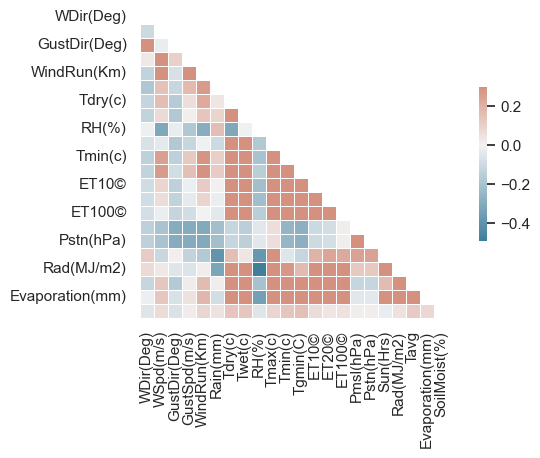

In [42]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = motat.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
soil_moisture = motat['SoilMoist(%)'].values
rainfall = motat['Rain(mm)'].values
temp = motat['Tgmin(C)'].values

In [44]:
lag_size = 30
# Calculate cross-correlation for rainfall and soil temperature
lags_rain_temp, correlation_rain_temp = cross_correlation(rainfall, temp, lag_size)
print("Cross-Correlation between Rainfall and Soil Temperature:")
print("Lags:", lags_rain_temp)
print("Correlation:", correlation_rain_temp)

Cross-Correlation between Rainfall and Soil Temperature:
Lags: [-2938 -2937 -2936 ...  2936  2937  2938]
Correlation: [5.22000000e+00 1.45800000e+01 2.71800000e+01 ... 1.28800000e+02
 0.00000000e+00 9.93410746e-12]


In [45]:

# Calculate cross-correlation for rainfall and soil moisture
lags_rain_moist, correlation_rain_moist = cross_correlation(rainfall, soil_moisture, lag_size)
print("\nCross-Correlation between Rainfall and Soil Moisture:")
print("Lags:", lags_rain_moist)
print("Correlation:", correlation_rain_moist)


Cross-Correlation between Rainfall and Soil Moisture:
Lags: [-2938 -2937 -2936 ...  2936  2937  2938]
Correlation: [ 7.09200000e+01  7.09200000e+01  7.09200000e+01 ...  2.61800000e+02
 -5.96046448e-11 -1.98682149e-11]


In [46]:
# Calculate cross-correlation for soil moisture and soil temperature
lags_moist_temp, correlation_moist_temp = cross_correlation(soil_moisture, temp, lag_size)
print("\nCross-Correlation between Soil Moisture and Soil Temperature:")
print("Lags:", lags_moist_temp)
print("Correlation:", correlation_moist_temp)


Cross-Correlation between Soil Moisture and Soil Temperature:
Lags: [-2938 -2937 -2936 ...  2936  2937  2938]
Correlation: [ 108.46  411.98  978.34 ... 1828.16 1331.72  724.96]


Predictive Model

In [47]:
rainfall_lags = [7, 14, 30, 60]  
temp_lags = [1, 3, 7, 14, 14, 30, 60] 

for i in rainfall_lags:
    motat[f'Rainfall_lag_{i}'] = motat['Rain(mm)'].shift(i)


for i in temp_lags:
    motat[f'Temp_lag_{i}'] = motat['Tgmin(C)'].shift(i)

# Drop rows with NaN values in the lag features
motat.dropna(inplace=True)

In [48]:
motat.columns

Index(['WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)',
       'Rain(mm)', 'Tdry(c)', 'Twet(c)', 'RH(%)', 'Tmax(c)', 'Tmin(c)',
       'Tgmin(C)', 'ET10©', 'ET20©', 'ET100©', 'Pmsl(hPa)', 'Pstn(hPa)',
       'Sun(Hrs)', 'Rad(MJ/m2)', 'Tavg', 'Evaporation(mm)', 'SoilMoist(%)',
       'Rainfall_lag_7', 'Rainfall_lag_14', 'Rainfall_lag_30',
       'Rainfall_lag_60', 'Temp_lag_1', 'Temp_lag_3', 'Temp_lag_7',
       'Temp_lag_14', 'Temp_lag_30', 'Temp_lag_60'],
      dtype='object')

In [49]:
X = motat.drop(columns=['SoilMoist(%)'])


y = motat[['SoilMoist(%)']]

X.dropna(inplace=True)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2879, 31)
y shape: (2879, 1)


In [50]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
# Random Forest model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

c:\Users\Ying\.conda\envs\level8\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

def evaluate_model(predictions, y_test):
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    r2 = r2_score(y_test, predictions)

    return mae, mse, rmse, r2

rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)

print("\nRandom Forest Testing Set Metrics:")
print(f"MAE: {rf_mae}")
print(f"MSE: {rf_mse}")
print(f"RMSE: {rf_rmse}")
print(f"R2 Score: {rf_r2}")


Random Forest Testing Set Metrics:
MAE: 1.746939236111111
MSE: 4.632033241319444
RMSE: 2.1522158909643436
R2 Score: 0.3216161544189936


In [53]:
motat.columns

Index(['WDir(Deg)', 'WSpd(m/s)', 'GustDir(Deg)', 'GustSpd(m/s)', 'WindRun(Km)',
       'Rain(mm)', 'Tdry(c)', 'Twet(c)', 'RH(%)', 'Tmax(c)', 'Tmin(c)',
       'Tgmin(C)', 'ET10©', 'ET20©', 'ET100©', 'Pmsl(hPa)', 'Pstn(hPa)',
       'Sun(Hrs)', 'Rad(MJ/m2)', 'Tavg', 'Evaporation(mm)', 'SoilMoist(%)',
       'Rainfall_lag_7', 'Rainfall_lag_14', 'Rainfall_lag_30',
       'Rainfall_lag_60', 'Temp_lag_1', 'Temp_lag_3', 'Temp_lag_7',
       'Temp_lag_14', 'Temp_lag_30', 'Temp_lag_60'],
      dtype='object')

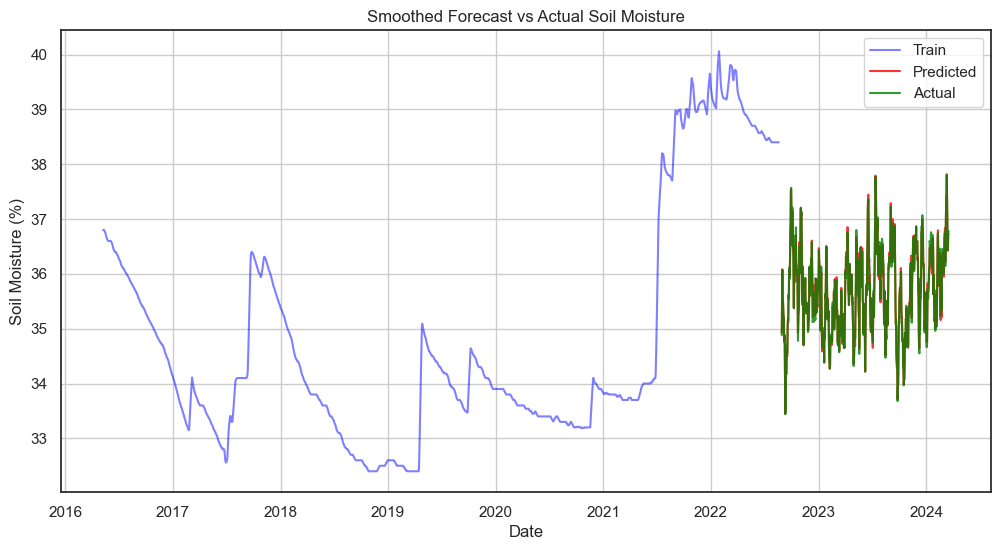

In [ ]:
results_df_smoothed = results_df[['SoilMoist(%)', 'Predicted SoilMoist(%)']].rolling(window=10).mean()

plt.figure(figsize=(12, 6))
plt.plot(motat['SoilMoist(%)'][:len(X_train)].rolling(window=10).mean(), label='Train', color='blue', alpha=0.5)
plt.plot(results_df.index, results_df_smoothed['Predicted SoilMoist(%)'], color='red', label='Predicted', alpha=0.8)
plt.plot(results_df.index, results_df_smoothed['SoilMoist(%)'], color='green', label='Actual', alpha=0.8)

plt.title('Smoothed Forecast vs Actual Soil Moisture')
plt.xlabel('Date')
plt.ylabel('Soil Moisture (%)')
plt.legend()
plt.grid()
plt.show()


In [ ]:


# # allstation = ['MtAlbert', 'Ararimu', 'Awhitu', 'Kaipara', 'Mangemangeroa', 'Tomarata', 'waitangi', 'whangamarie']

# metrics_data = {
#     'Station': ['Mt Albert', 'Ararimu', 'Awhitu'],
#     'MAE': [0.01098, 1.2, 1.5], 
#     'MSE': [0.00038, 1.8, 2.1],
#     'RMSE': [0.01953, 1.3, 1.8],
#     'R2 Score': [0.99999, 0.75, 0.70],
# }

# metrics_df = pd.DataFrame(metrics_data)

# metrics_df.set_index('Station').plot(kind='bar', figsize=(5, 4))
# plt.title('Model Evaluation Metrics Comparison')
# plt.ylabel('Metric Value')
# plt.xticks(rotation=0)
# plt.grid(axis='y')
# plt.legend(title='Metrics')
# plt.show()